In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from scipy import sparse
from typing import List
from sklearn.metrics import log_loss, roc_auc_score


Прочитаем данные, выделив сразу необходимые нам фичи

In [2]:
full_data = pd.read_csv(
    'data/data.csv',
    usecols=[
        'date_time',
        'zone_id',
        'banner_id',
        'campaign_clicks',
        'os_id',
        'country_id',
        'impressions',
        'clicks'
    ],
    parse_dates=['date_time'],
    infer_datetime_format=True
)
full_data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


# Analysis

В первую очередь проверим данные на пропуски, и увидим, что их там нет)

In [3]:
full_data.isna().any()

date_time          False
zone_id            False
banner_id          False
campaign_clicks    False
os_id              False
country_id         False
impressions        False
clicks             False
dtype: bool

Для удобства разобьём фичу `date_time` на две отдельные фичи

In [4]:
full_data['date'] = full_data['date_time'].dt.date
full_data['time'] = full_data['date_time'].dt.time

Посмотрим на распределение предоставленных данных во времени


In [5]:
full_data.date.value_counts()

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64

Заметим, что есть ровно один прецедент от `2021-09-01`. Выглядит как выброс, поэтому избавимся от него.

Также сразу разобьём данные на тест (последний день) и трейн (всё остальное)

In [6]:
full_data = full_data[full_data.date != pd.Timestamp('2021-09-01').date()]

full_data_test = full_data[full_data.date == pd.Timestamp('2021-10-02').date()]
full_data_train = full_data[full_data.date != pd.Timestamp('2021-10-02').date()]

Дальше будем анализировать кусок данных для обучения.

In [7]:
full_data_train.describe()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
count,1.369249e+07,1.369249e+07,1.369249e+07,1.369249e+07,1.369249e+07,13692493.0,1.369249e+07
mean,7.963735e+01,3.742884e+02,6.520606e-01,1.833020e+00,4.392995e+00,1.0,2.533410e-02
std,1.579126e+02,3.926496e+02,9.629881e+00,1.512653e+00,4.329281e+00,0.0,1.571378e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,1.400000e+01,4.900000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,1.900000e+01,2.050000e+02,0.000000e+00,2.000000e+00,4.000000e+00,1.0,0.000000e+00
75%,5.900000e+01,6.100000e+02,0.000000e+00,3.000000e+00,7.000000e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.0,1.000000e+00


Из доступных фичей не категориальной является только `campaign_clicks`.
Для оставшихся категориальных фичей интересно посмотреть на количество и распределение их значений.

In [8]:
categorical_features = ['country_id', 'os_id', 'zone_id', 'banner_id', 'impressions']
numerical_features = ['campaign_clicks']

Посмотрим на количество различных значений в каждой категориальной фиче.

Сразу увидим, что фича `impressions` -- это просто константа, поэтому позже избавимся от неё.

In [9]:
full_data_train[categorical_features].nunique()

country_id       17
os_id            11
zone_id        3330
banner_id      1586
impressions       1
dtype: int64

Для двух немногочисленных категориальных фичей, посмотрим на точное распределение количества их значений.

И увидим, что фича `os_id` имеет 11 значений, 4 из которых очень редкие

<AxesSubplot: title={'center': 'os_id'}>

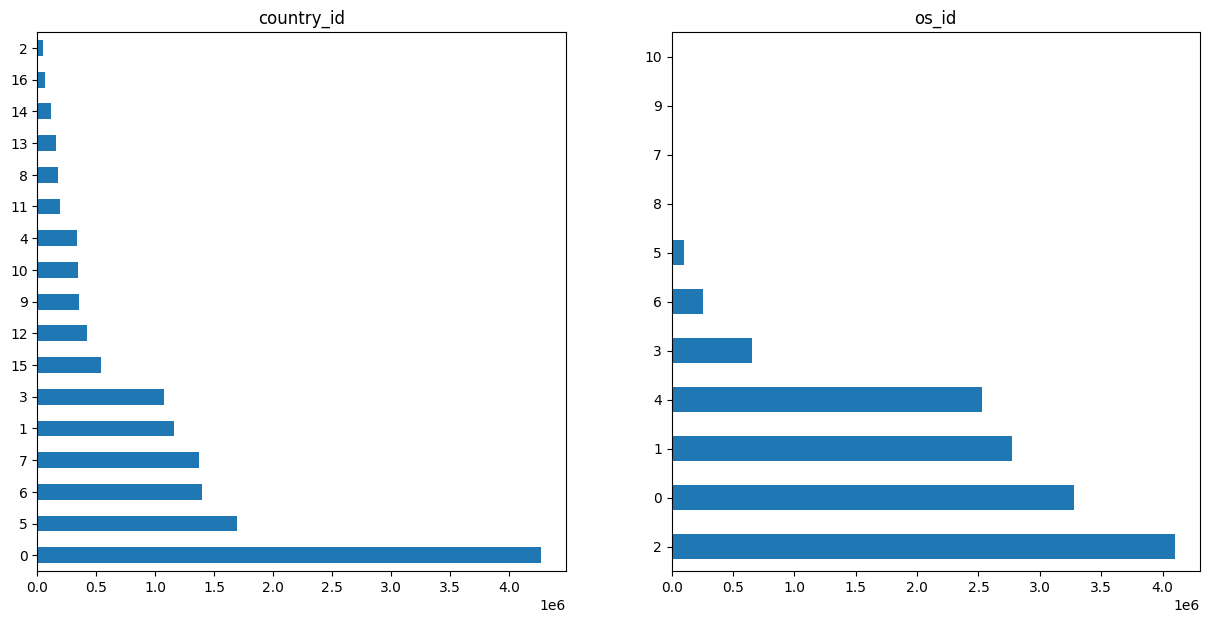

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
full_data_train['country_id'].value_counts().plot(kind='barh', ax=ax1, title='country_id')
full_data_train['os_id'].value_counts().plot(kind='barh', ax=ax2, title='os_id')

Фичи `zone_id` и `banner_id` имеют слишком много значений, посмотрим на гистограмму распределения их значений.

Здесь видно, что некоторые значения фичи принимают очень редко.

<AxesSubplot: title={'center': 'banner_id'}, ylabel='Frequency'>

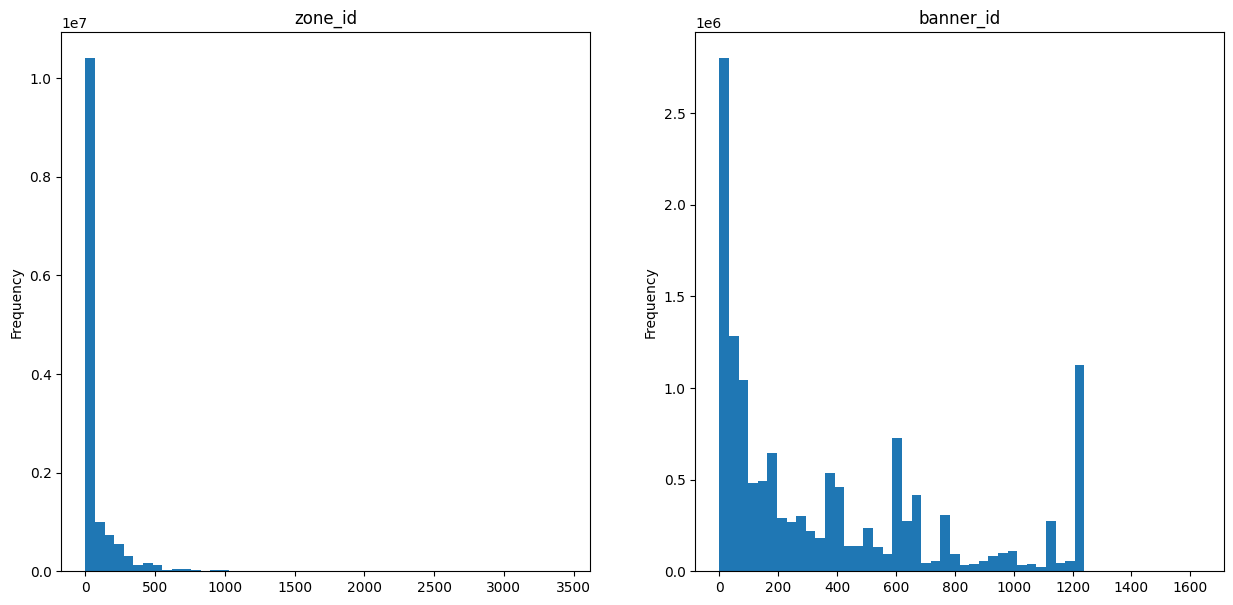

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
full_data_train['zone_id'].plot(kind='hist', bins=50, ax=ax1, title='zone_id')
full_data_train['banner_id'].plot(kind='hist', bins=50, ax=ax2, title='banner_id')

Итак, по предыдущим 3 ячейкам мы выяснили про категориальные фичи следующее:

* `impressions` -- константа
* `country_id`, `os_id` -- не очень многочисленные и последняя из них среди 11 значений имеет 4 очень редких
* `zone_id`, `banner_id` -- имеют много значений, некоторые из которых встречаются редко

По-хорошему, редкие значения фичей можно было бы объединить в одну группу (отдельное значение), но тогда в случае фичей `zone_id` и `banner_id` дополнительно придётся подбирать константы, по которым стоит объединять редкие значения в одно. Чтобы не вводить это дополнительное усложнение, делать этого не будем. Кроме того, немного поэкспериментировав с этим, я не увидел значительного улучшения качества.

Также не будем забывать про временную фичу.

Из дней обычно можно вытянуть фичу `день недели`, но у нас всего 6 дней в тренировочных данных, поэтому делать этого не будем.

Но можно выделить фичу `час дня` для него данные есть. Данная фича, может быть осмысленной, так как в разное время дня людям может быть интересны разные вещи.

# Feature engineering

Избавимся от константной фичи `impressions`

In [12]:
categorical_features.remove('impressions')
full_data_train = full_data_train.drop('impressions', axis=1)
full_data_test = full_data_test.drop('impressions', axis=1)

Добавим фичу час дня и убедимся, что мы имеем прецедентов для каждого часа

<AxesSubplot: title={'center': 'day_hour'}>

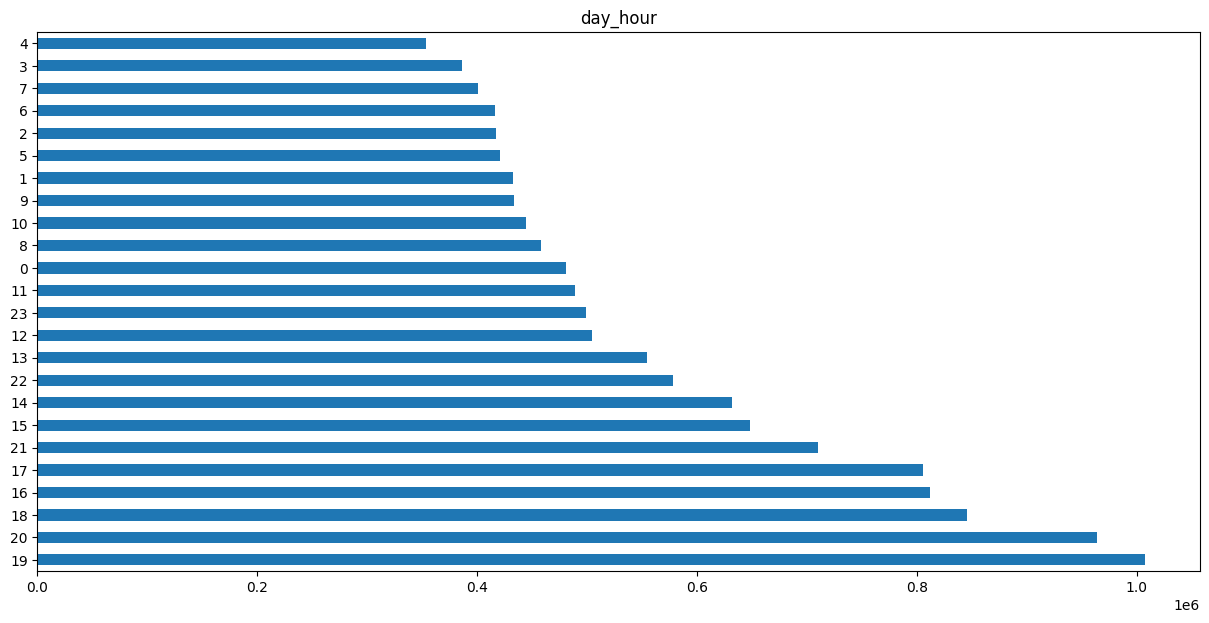

In [13]:
full_data_train['day_hour'] = full_data_train.date_time.dt.hour
full_data_test['day_hour'] = full_data_test.date_time.dt.hour
categorical_features.append('day_hour')

fig, (ax1) = plt.subplots(1, 1)
fig.set_figheight(7)
fig.set_figwidth(15)
full_data_train['day_hour'].value_counts().plot(kind='barh', ax=ax1, title='day_hour')

Отделим таргет фичу (`clicks`) от остальных. Перед этим данные для обучения отсортируем по `date_time`. Это нужно будет для дальнейшей кросс валидации

In [14]:
full_data_train = full_data_train.sort_values(by=['date_time']) # Необходимо для дальшейшего cv

y_train = full_data_train['clicks'].to_numpy()
data_train = full_data_train.drop('clicks', axis=1)
print(f"Train size: {len(data_train)}")

y_test = full_data_test['clicks'].to_numpy()
data_test = full_data_test.drop('clicks', axis=1)
print(f"Test size: {len(data_test)}")

Train size: 13692493
Test size: 2128978


In [15]:
data_train.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,date,time,day_hour
14471546,2021-09-26,11,73,9,4,13,2021-09-26,00:00:00,0
15802991,2021-09-26,105,21,0,0,0,2021-09-26,00:00:00,0
5041415,2021-09-26,41,29,1,3,0,2021-09-26,00:00:00,0
9316416,2021-09-26,23,1239,0,2,0,2021-09-26,00:00:00,0
3068105,2021-09-26,86,61,0,0,1,2021-09-26,00:00:00,0


Наконец напишем функцию, которая будет преобразовывать фичи из `pd.DataFrame` в удобный матричный вид для обучения модели.

Преобразование фич:

* Числовые фичи приводим к нулевому среднему и единичной дисперсии
* Категориальные фичи кодируем с помощью `OneHotEncoder`-а

При этом параметры для скейлера для числовых фич и енкодера для категориальных фич подбираются только на обучающей выборке.

Данные для обучения у нас будут разряженными, так как большинство фичей у нас категориальные и мы используем one-hot кодирование.

Поэтому преобразованные данные для обучения -- это разряженная по строкам матрица


In [16]:
def transform_data(data_train: pd.DataFrame, data_test: pd.DataFrame, categorical_features: List[str], continuous_features: List[str]):
    X_train = []
    X_test = []

    for feature in continuous_features:
        scaler = StandardScaler().fit(data_train[[feature]])
        X_train.append(sparse.csr_matrix(scaler.transform(data_train[[feature]])))
        X_test.append(sparse.csr_matrix(scaler.transform(data_test[[feature]])))

    for feature in categorical_features:
        encoder = OneHotEncoder(handle_unknown='ignore').fit(data_train[[feature]])
        X_train.append(encoder.transform(data_train[[feature]]))
        X_test.append(encoder.transform(data_test[[feature]]))

    return sparse.hstack(X_train), sparse.hstack(X_test)

# Model training

Для решения логистической регрессии будем использовать не SGD-like `liblinear` solver с `l2` регуляризацией.
Метод эффективно находит решение регрессии для sparse данных. А это как раз наш случай)

In [17]:
def create_model(X, y, C):
    return LogisticRegression(solver='liblinear', penalty='l2', C=C, random_state=42).fit(X, y)

Реализуем подсчёт необходимых метрик из условия задания

In [18]:
def get_score(y_true, y_pred):
    # y_pred.shape == [N, 2].
    # Первый столбец -- вероятности 0 (отсутствия клика)
    # Второй столбец -- вероятность 1 (клика)
    return {
        'log-loss': log_loss(y_true, y_pred),
        'roc-auc': roc_auc_score(y_true, y_pred[:, 1])
    }

Реализуем кросс валидацию. При этом обычную кросс-валидацию использовать не стоит, так как данные из будущего могут создавать утечку данных. Поэтому используем кросс валидацию, в которой обучающей выборкой для валидационной выборки являются все данные из прошлого.

Используем 5 фолдов, так как в обучающей выборке -- 6 дней:
* Один фолд -- это примерно предсказание одного дня по данным с предыдущих дней (Схоже с нашей итоговой задачей)

In [19]:
def cv(X, y, C, categorical_features, continuous_features):
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train, val in tqdm(tscv.split(X), total=5):
        y_train = y[train]
        data_train = X.iloc[train]

        y_val = y[val]
        data_val = X.iloc[val]

        X_train, X_val = transform_data(
            data_train,
            data_val,
            categorical_features,
            continuous_features
        )

        model = create_model(X_train, y_train, C=C)

        y_pred = model.predict_proba(X_val)
        score = get_score(y_val, y_pred)
        scores.append(score)

    return {key: [v[key] for v in scores] for key in scores[0].keys()}

Подбирать будем коэффициент `C`, характеризующий вклад регуляризации в итоговой лосс

In [24]:
def search_regularization_coeff(X, y, categorical_features, continuous_features):
    result = {}
    for C in [0.001, 0.01, 0.1, 1]:
        result[C] = cv(X, y, C, categorical_features, continuous_features)
    return result

def summarize_search_result(search_result):
    summary = {}
    for C, result in search_result.items():
        summary[C] = {metric: np.mean(scores) for metric, scores in result.items()}
    return summary

Наконец, обучим модель с фичами, которые построили до этого

In [25]:
without_interactions_cv = search_regularization_coeff(data_train, y_train, categorical_features, numerical_features)

100%|██████████| 5/5 [05:17<00:00, 63.49s/it]


In [26]:
print(json.dumps(without_interactions_cv, sort_keys=True, indent=4))

{
    "0.001": {
        "log-loss": [
            0.08384484921912998,
            0.08703211168762222,
            0.10441376120319185,
            0.1365068628027265,
            0.155664643814434
        ],
        "roc-auc": [
            0.6836949154990258,
            0.692406563792316,
            0.6816306624778017,
            0.710917551512213,
            0.7642140533468552
        ]
    },
    "0.01": {
        "log-loss": [
            0.08142609444406644,
            0.08512427486307206,
            0.10207243889463997,
            0.13270555147457996,
            0.15196361295480548
        ],
        "roc-auc": [
            0.7163212171702228,
            0.717067374348014,
            0.7128255875518915,
            0.73407990771145,
            0.7751471613840127
        ]
    },
    "0.1": {
        "log-loss": [
            0.08041620437392008,
            0.0843220905362249,
            0.10132979897517233,
            0.13171177408569812,
            0.150958069

Для получения summary усредним значения по фолдам:

In [27]:
print(json.dumps(summarize_search_result(without_interactions_cv), sort_keys=True, indent=4))

{
    "0.001": {
        "log-loss": 0.1134924457454209,
        "roc-auc": 0.7065727493256424
    },
    "0.01": {
        "log-loss": 0.11065839452623279,
        "roc-auc": 0.7310882496331182
    },
    "0.1": {
        "log-loss": 0.10974758751442701,
        "roc-auc": 0.7369764116113687
    },
    "1": {
        "log-loss": 0.10966304917558918,
        "roc-auc": 0.7371687873197292
    }
}


Лучший результат здесь достигается с `C=1`:
* средний `log-loss` = 0.10966304917558918
* средний `roc-auc` = 0.7371687873197292

# Feature engineering again

Вспомним про то, что для улучшения качества линейных моделей можно добавлять интеракции фичей

Добавление интеракции в датасет реализуем наиболее удобным способом:
* Добавим в `pd.DataFrame` новую колонку, значения которой -- это конкатенация строкового представления значений взаимодействующих фич
* После применения `OneHotEncoder` получим то же самое, что получили бы при произведении соответствующих колонок матрицы данных, за исключением колонок, где все значения одинаковы.

In [20]:
def add_interaction(data: pd.DataFrame, interacting_features: List[str]):
    def create_interaction(row):
        interaction = []
        for feature in interacting_features:
            interaction.append(str(row[feature]))
        return ":".join(interaction)
    new_column_name = ":".join(interacting_features)
    print(f"New column name: {new_column_name}")
    data[new_column_name] = data.apply(create_interaction, axis=1)

Из имеющихся одиночных фичей осмысленными кажутся следующие:
* `banner_id` + `country_id` -- баннер может быть ориентирован на определённую страну
* `zone_id` + `os_id` -- разные зоны воспринимаются на разных устройствах по разному
* `banner_id` + `os_id` -- баннеры для мобильных устройств могут отличаться от баннеров для компьютеров
* `banner_id` + `day_hour` -- в разное время дня могут быть интересны разные рекламы
* `banner_id` + `zone_id` -- разные баннеры могут смотреться в разных зонах по-разному

Добавим все интеракции кроме последней, так как `banner_id` и `zone_id` -- две самые многочисленные фичи, следовательно, интеракция будет иметь слишком много значений.

In [21]:
interactions = [
    ['banner_id', 'country_id'],
    ['zone_id', 'os_id'],
    ['banner_id', 'os_id'],
    ['banner_id', 'day_hour']
]
for interaction in interactions:
    add_interaction(data_train, interaction)
    add_interaction(data_test, interaction)

New column name: banner_id:country_id
New column name: banner_id:country_id
New column name: zone_id:os_id
New column name: zone_id:os_id
New column name: banner_id:os_id
New column name: banner_id:os_id
New column name: banner_id:day_hour
New column name: banner_id:day_hour


In [22]:
data_train.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,date,time,day_hour,banner_id:country_id,zone_id:os_id,banner_id:os_id,banner_id:day_hour
14471546,2021-09-26,11,73,9,4,13,2021-09-26,00:00:00,0,73:13,11:4,73:4,73:0
15802991,2021-09-26,105,21,0,0,0,2021-09-26,00:00:00,0,21:0,105:0,21:0,21:0
5041415,2021-09-26,41,29,1,3,0,2021-09-26,00:00:00,0,29:0,41:3,29:3,29:0
9316416,2021-09-26,23,1239,0,2,0,2021-09-26,00:00:00,0,1239:0,23:2,1239:2,1239:0
3068105,2021-09-26,86,61,0,0,1,2021-09-26,00:00:00,0,61:1,86:0,61:0,61:0


# Model training again

Обучим модель с добавленными интеракциями

In [28]:
with_interactions = search_regularization_coeff(
    data_train,
    y_train,
    categorical_features + ['banner_id:country_id', 'zone_id:os_id', 'banner_id:os_id', 'banner_id:day_hour'],
    numerical_features
)

100%|██████████| 5/5 [14:44<00:00, 176.98s/it]


In [29]:
print(json.dumps(with_interactions, sort_keys=True, indent=4))

{
    "0.001": {
        "log-loss": [
            0.08291959713671528,
            0.0861016938806844,
            0.10315869143119859,
            0.1343377680495446,
            0.15313711926957482
        ],
        "roc-auc": [
            0.7019028083701491,
            0.7073801041262776,
            0.7005811771766821,
            0.7278336107981803,
            0.7735300839720598
        ]
    },
    "0.01": {
        "log-loss": [
            0.08043619366344072,
            0.0842165349728861,
            0.1009626620661574,
            0.13105049897312437,
            0.15000558231032063
        ],
        "roc-auc": [
            0.7309109931565999,
            0.7293513048765566,
            0.7258354005060914,
            0.7443223431063092,
            0.7828186998972082
        ]
    },
    "0.1": {
        "log-loss": [
            0.07963055758784486,
            0.08368385162308933,
            0.10046767991310294,
            0.13052188624297795,
            0.1495

In [30]:
print(json.dumps(summarize_search_result(with_interactions), sort_keys=True, indent=4))

{
    "0.001": {
        "log-loss": 0.11193097395354354,
        "roc-auc": 0.7222455568886698
    },
    "0.01": {
        "log-loss": 0.10933429439718582,
        "roc-auc": 0.7426477483085531
    },
    "0.1": {
        "log-loss": 0.10877941273933671,
        "roc-auc": 0.7459082743932411
    },
    "1": {
        "log-loss": 0.1097407068267843,
        "roc-auc": 0.7381055467180406
    }
}


Здесь лучший результат также здесь достигается с `C=0.1`:
* средний `log-loss` = 0.10877941273933671
* средний `roc-auc` = 0.7459082743932411

# Final model training

Обучим лучшую модель (модель с интеракциями и `C=0.1`) на всех тренировочных данных:

In [23]:
X_train, X_test = transform_data(
    data_train,
    data_test,
    categorical_features + ['banner_id:country_id', 'zone_id:os_id', 'banner_id:os_id', 'banner_id:day_hour'],
    numerical_features
)

model = create_model(X_train, y_train, C=0.1)

Посчитаем метрики на тесте (на последнем дне):

In [24]:
y_pred = model.predict_proba(X_test)
best_score = get_score(y_test, y_pred)
print(json.dumps(best_score, sort_keys=True, indent=4))

{
    "log-loss": 0.13148437882433509,
    "roc-auc": 0.7919810325455986
}


Сравнимся с baseline-ом -- средним по тестовой выборке:

In [26]:
test_mean = y_test.mean()
y_base = np.array([[1 - test_mean, test_mean]]).repeat(len(y_test), axis=0)

base_score = get_score(y_test, y_base)
print(json.dumps(base_score, sort_keys=True, indent=4))

{
    "log-loss": 0.15303289904918538,
    "roc-auc": 0.5
}


Получили метрики лучше бейзлайна